# SAMとSEMのプログラムを一つにまとめたときのプログラム

# インポート

In [1]:
import cdt
import networkx as nx
from cdt.causality.graph import SAM
from cdt.data import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import decimal
import semopy as sm
from semopy import inspector

from tqdm.notebook import tqdm
import pickle
import os

np.set_printoptions(precision=5)
pd.options.display.max_columns=1000
pd.options.display.max_rows = 1000
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Detecting 2 CUDA device(s).


# 関数と定数の定義

In [2]:
# DATA_PATH = './data/Acidosis_30m_dataset.csv'
DATA_PATH = './data/CTU_30m.csv'
# DATA_PATH = './data/Acidosis_30m_dataset.csv'
RESULT_FOLDER = 'v6_20220608'    # SAMを実行した結果を入れるフォルダの名前
# lambda1_list = [0.0, 0.001, 0.002, 0.01, 0.02, 0.1, 0.2, 1.0, 2.0] # λs
# lambda2_list = [0.002, 0.001, 0.0002, 0.0001, 2e-05, 1e-05, 2e-06, 1e-06, 2e-07] # λf
# lambda1_list = [0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0] # λs
# lambda2_list = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1.0] # λf
lambda1_list = np.round(np.arange(5, 15, 0.1), 2)
lambda1_str_list = lambda1_list.astype('str')
lambda1_str_list = list(map(lambda y:y.replace('.', '-'), lambda1_str_list))
nruns_list = [32, 64, 96] # SAMの平均を取る時の母数
threshold_list = np.round(np.arange(0.5, 0.75, 0.05), 3) # パス解析の時に使う閾値

epochs_list = np.round(np.array([3000, 6000, 12000, 24000]))

# lambda1_str_list = list(map(lambda x:str(x).replace('.', '-'), lambda1_list))
# lambda2_str_list = list(map(lambda x:str(x).replace('.', '-'), lambda2_list))

In [3]:
# 表を見やすくする
def CreateMatrix(df):
    np.set_printoptions(precision=5, suppress=True)
    num = len(df['index'].unique())
    mon = np.eye(num, M=None)
    uni = np.array(list(df['index'].unique()))
    x = np.arange(0, num)
    for i in x:
        for j in x:
            if i == j:
                value = 0
            else:
                value = df.loc[(df['index'] == uni[i]) & (df['target'] == uni[j]), 'weight'].iloc[-1]
            mon[i,j] = value
    return pd.DataFrame(mon, index = uni, columns=uni)

# SAMの実行関数
def act(data, nruns, lam1, lam2, njobs, train_epochs=10000, test_epochs=2000, gpus=2):
    obj = SAM(lambda1=lam1, lambda2=lam2,
              train_epochs=train_epochs, test_epochs=test_epochs,
              nruns=nruns,njobs=njobs,gpus=gpus)
    
    output,matrix = obj.predict(data, graph=None, return_list_results=False)
    data_list = output.edges(data=True)
    index_list = [list(data_list)[i][0] for i in range(len(list(data_list)))]
    target_list = [list(data_list)[i][1] for i in range(len(list(data_list)))]
    weight_list = [list(data_list)[i][2]['weight'] for i in range(len(list(data_list)))]
    dataframe = pd.DataFrame(list(zip(index_list,target_list,weight_list)),columns=['index','target','weight'])
    matrix = CreateMatrix(dataframe)
    return matrix

def heatmap(SAM, dfs):
    plt.figure(figsize=(12, 10))
    sns.set(font_scale=1.2)
    sns.heatmap(SAM, linewidth=0.3, cmap='summer_r', xticklabels=list(dfs['name_simple'].values),
               yticklabels=list(dfs['name_simple'].values), annot=True, annot_kws={"size": 13}, fmt="1.3f")
    display(plt.show())
    

def make_mod(matrix, df):
    '''semopyに入れるための因果関係のやつを作る
    '''
    df_name = list(df.columns)
    set_edge_model = []
    
    for num1, i in enumerate(matrix):
        for num2, j in enumerate(i):
            if j == 1:
                set_edge_model.append(df_name[num2].replace(' ', '') + " ~ " + df_name[num1].replace(' ', ''))

    mod = ""
    for i in set_edge_model:
        mod += i
        mod += "\n"
    return mod

def make_cal(matrix, df_name):
    df_name = df_name
    cal_full = ""
    set_edge_model = []
    for num1, i in enumerate(matrix.T):
        cal = ""
        flg = 0
        for num2, j in enumerate(i):
            if j == 1 and flg == 0:
                cal += (df_name[num1] + " = " + df_name[num2])
                flg = 1
            elif j == 1 and flg == 1:
                cal += " + " + df_name[num2]
            else:
                pass
        if flg == 1:
            cal_full += cal + "\n"
    return cal_full

def cal_pass(mod, df, detail=True):
    np.set_printoptions(precision=10, suppress=True)

    model = sm.Model(mod)
    model.load_dataset(df)
    opt = sm.Optimizer(model)
    objective_function_value = opt.optimize()

    if detail:
        with open('./sem_graph/pickle_files/inspector.pickle', 'wb') as f:
            pickle.dump(sm.inspector.inspect(opt, std_est=True), f)

    model.fit(df)
    stats = sm.gather_statistics(opt)
    if detail:
        with open('./sem_graph/pickle_files/calc_stats.pickle', 'wb') as f:
            pickle.dump(sm.calc_stats(model).T, f)
    return np.round(stats[6], 5), np.round(stats[8], 5), np.round(stats[9], 5), np.round(stats[12], 5)

def show_heatmap(name, folder_name, origin_data_path='./data/Acidosis_30m_dataset.csv',
                 name_simple_columns=['pH', 'Ab', 'Min', 'Mod', 'Mar', 'Base', 'Acc', 'ED', 
                   'VD_Mil', 'VD_Sev', 'LD_Mil', 'LD_Sev', 'PD_Mil', 'PD_Sev']):
    df = pd.read_csv(f'./sam_result/{folder_name}/{name}.csv', index_col=0)
    
    df_origin = pd.read_csv(origin_data_path)
    df_to_simple_names = pd.DataFrame({'name': list(df_origin.columns)})
    df_to_simple_names['name_simple'] = name_simple_columns
    
    heatmap(df, df_to_simple_names)
    

# ヒートマップ表示とパス解析評価指標のデータフレーム作成

def heatmap_savedf(folder_name, threshold, 
                   name_simple_columns=['pH', 'Ab', 'Min', 'Mod', 'Mar', 'Base', 'Acc', 'ED', 
                                       'VD_Mil', 'VD_Sev', 'LD_Mil', 'LD_Sev', 'PD_Mil', 'PD_Sev'],
                   origin_data_path='./data/Acidosis_30m_dataset.csv', result_path='./sam_result/',
                   save_dataframe=True,
                   eval_index=['name', 'rmsea', 'gfi', 'agfi', 'aic']):
    
    np.set_printoptions(precision=10, suppress=True)
    df_origin = pd.read_csv(origin_data_path)
    df_to_simple_names = pd.DataFrame({'name': list(df_origin.columns)})
    df_to_simple_names['name_simple'] = name_simple_columns
    df_sem = pd.DataFrame(columns=eval_index)
    
    file_list = os.listdir(f'./sam_result/{folder_name}')
    if '.ipynb_checkpoints' in file_list:
        file_list.pop(file_list.index('.ipynb_checkpoints'))

    
    for file_i, file in enumerate(tqdm(file_list)):
        file_name = file.split('.')[0]
#         print(file_name)
        try:
            df = pd.read_csv(f'./sam_result/{folder_name}/{file_name}.csv', index_col=0)
        except:
            continue
#         print(file_name, threshold)
#         heatmap(df, df_to_simple_names)

        if save_dataframe:
            array_sam_01data = np.where(df > threshold, 1, 0)
            if array_sam_01data.sum() <= 0:
                continue
            mod = make_mod(array_sam_01data, df_origin)
#             print(mod)
            df_origin_columns = list(df_origin.columns)
            df_origin_columns_not = df_origin_columns.copy()

            for i, oc in enumerate(df_origin_columns):
                oc = oc.replace(' ', '')
                df_origin_columns_not[i] = oc

            df_origin_not = df_origin.set_axis(df_origin_columns_not, axis=1)
            try:
                rmsea, gfi, agfi, aic = cal_pass(mod, df_origin_not, detail=False)
            except:
                continue
            print(mod)
            if 'pH' in mod:
                df_sem = df_sem.append({'name':f'{file_name}_{threshold}',
                                        'rmsea':rmsea, 'gfi':gfi, 'agfi':agfi, 'aic':aic}, ignore_index=True)
#             df_sem = df_sem.append({'name':f'{file_name}_{threshold}',
#                                     'rmsea':rmsea, 'gfi':gfi, 'agfi':agfi, 'aic':aic}, ignore_index=True)
                    
    return df_sem

# SEM詳細表示
def SEM(file_name, folder_name=RESULT_FOLDER, threshold=0.5, 
        name_simple_columns=['pH', 'Ab', 'Min', 'Mod', 'Mar', 'Base', 'Acc', 'ED', 
                             'VD_Mil', 'VD_Sev', 'LD_Mil', 'LD_Sev', 'PD_Mil', 'PD_Sev'],
        origin_data_path='./data/CTU_30m.csv', result_path='./sam_result',
        heatmap=False):
    
    graph_folder = f'sem_graph/{folder_name}'
    png_name = f'{file_name}'

    df_origin = pd.read_csv(origin_data_path)
    dfs = pd.DataFrame({'name': list(df_origin.columns)})
    dfs['name_simple'] = name_simple_columns
    df = pd.read_csv(f'{result_path}/{folder_name}/{file_name}.csv', index_col=0)
    array_sam01 = np.where(df > threshold, 1, 0)
    mod = make_mod(array_sam01, df_origin)
    print(mod)
    
    df_origin_columns = list(df_origin.columns)
    df_origin_columns_not = df_origin_columns.copy()

    for i, oc in enumerate(df_origin_columns):
        oc = oc.replace(' ', '')
        df_origin_columns_not[i] = oc

    df_origin_not = df_origin.set_axis(df_origin_columns_not, axis=1)
    
    rmsea, gfi, agfi, aic = cal_pass(mod, df_origin_not)
    print(rmsea)

    m = sm.Model(mod)
    m.fit(df_origin_not)
    
    check_folder(graph_folder)
    display(sm.semplot(m, 
            f'{graph_folder}/rmsea{str(rmsea).replace(".", "")}__th{str(threshold).replace(".","")}__{png_name}.png',
            plot_ests=True))
    with open('./sem_graph/pickle_files/calc_stats.pickle', 'rb')as f:
        print(pickle.load(f))
    print('')
    with open('./sem_graph/pickle_files/inspector.pickle', 'rb')as f:
        print(pickle.load(f))
    print('')
    print(make_cal(array_sam01, dfs['name_simple']))
    
    
def check_folder(folder_path):
    '''フォルダーが存在しているかどうかの確認と，作成
    '''
    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)

# データ読み込み

In [4]:
df_data = pd.read_csv(DATA_PATH)
# df_data.tail(2)
len(df_data)

495

# SAMの実行

In [5]:
# ハイパーパラメータ
lambda1 = lambda1_list[0]
# lambda2 = lambda2_list[0]
# lambda1_str = lambda1_str_list[0]
# lambda2_str = lambda2_str_list[0]
nruns = nruns_list[0]
train_epochs = 10000
test_epochs = 2000
njobs = 16

mat = act(df_data, 32, lambda1, 0.001, njobs, train_epochs=train_epochs, test_epochs=test_epochs, gpus=2) # この行でSAMを実行

  1%| | 160/12000 [00:07<08:53, 22.20it/s, disc=-.0265, gen=-1, regul_loss=1.41,



  1%| | 118/12000 [00:06<11:33, 17.14it/s, disc=-.0157, gen=-1, regul_loss=1.66,
  1%| | 134/12000 [00:06<10:08, 19.49it/s, disc=-.0211, gen=-1, regul_loss=1.69,


  1%| | 134/12000 [00:06<10:15, 19.28it/s, disc=-.0164, gen=-1, regul_loss=1.73,


  1%| | 149/12000 [00:07<09:24, 21.00it/s, disc=-.021, gen=-1, regul_loss=1.63, 
  1%| | 145/12000 [00:06<09:30, 20.79it/s, disc=-.0171, gen=-1.01, regul_loss=1.
  1%| | 140/12000 [00:06<09:48, 20.14it/s, disc=-.0158, gen=-.996, regul_loss=1.
  1%| | 141/12000 [00:06<09:41, 20.39it/s, disc=-.0213, gen=-.995, regul_loss=1.
  1%| | 143/12000 [00:07<09:47, 20.20it/s, disc=-.0209, gen=-1, regul_loss=1.53,
Process Process-31:
Process Process-32:
Traceback (most recent call last):
  File "/home/c0119097/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/c0119097/anaconda3/lib/py

KeyboardInterrupt: 

In [ ]:
# train_epochs = 3000
# test_epochs = 300
njobs = 28

# 保存先のフォルダがあるかどうかチェック
if not os.path.isdir('./sam_result'):
    os.mkdir('sam_result')
if not os.path.isdir(f'./sam_result/{RESULT_FOLDER}'):
    os.mkdir(f'./sam_result/{RESULT_FOLDER}')

for l1_i, l1 in enumerate(lambda1_list):
#     mat = act(df_data, 100, l1, 0.001, njobs, train_epochs=train_epochs, test_epochs=test_epochs) # この行でSAMを実行
    mat = act(df_data, 32, l1, 0.001, njobs) # この行でSAMを実行

    mat.to_csv(
        f'./sam_result/{RESULT_FOLDER}/{lambda1_str_list[l1_i]}.csv'
    ) # 結果を保存

100%|██████████| 12000/12000 [4:55:32<00:00,  1.48s/it, disc=-.0621, gen=-1.01, regul_loss=0.00825, tot=-14]]]

100%|█████████▉| 11971/12000 [4:53:24<00:23,  1.22it/s, disc=-.116, gen=-1, regul_loss=0.00826, tot=-13.9]4.2].82e+8]

100%|██████████| 12000/12000 [4:55:50<00:00,  1.48s/it, disc=-.0909, gen=-.997, regul_loss=0.00292, tot=-13.6]

100%|██████████| 12000/12000 [4:54:11<00:00,  1.47s/it, disc=0.516, gen=-.658, regul_loss=0.0043, tot=-9.13]3.83e+4]

100%|██████████| 12000/12000 [4:53:33<00:00,  1.47s/it, disc=-.0281, gen=-1.01, regul_loss=0.00343, tot=-13.5].73e+6]

100%|██████████| 12000/12000 [4:55:43<00:00,  1.48s/it, disc=1.22e+3, gen=-1.22e+3, regul_loss=0.00944, tot=-1.71e+4]

100%|██████████| 12000/12000 [2:20:17<00:00,  1.43it/s, disc=-.119, gen=-1.01, regul_loss=0.00424, tot=-14]


In [ ]:
# ハイパーパラメータ
# lambda1 = lambda1_list[0]
# lambda2 = lambda2_list[0]
# lambda1_str = lambda1_str_list[0]
# lambda2_str = lambda2_str_list[0]
# nruns = nruns_list[0]
# train_epochs = 3000
# test_epochs = 300
njobs = 16

# 保存先のフォルダがあるかどうかチェック
if not os.path.isdir('./sam_result'):
    os.mkdir('sam_result')
if not os.path.isdir(f'./sam_result/{RESULT_FOLDER}'):
    os.mkdir(f'./sam_result/{RESULT_FOLDER}')

for l1_i, l1 in enumerate(lambda1_list):
#     for l2_i, l2 in enumerate(lambda2_list):
    for ep_i, epoch in enumerate(epochs_list):
        train_epochs = int(epoch * 0.8)
        test_epochs = int(epoch * 0.2)
        mat = act(df_data, 32, l1, 0.001, njobs, train_epochs=train_epochs, test_epochs=test_epochs) # この行でSAMを実行

        mat.to_csv(
#             f'./sam_result/{RESULT_FOLDER}/{lambda1_str_list[l1_i]}_{lambda2_str_list[l2_i]}.csv'
            f'./sam_result/{RESULT_FOLDER}/{lambda1_str_list[l1_i]}_e{epoch}.csv'
        ) # 結果を保存

100%|█| 3000/3000 [02:19<00:00, 21.50it/s, disc=nan, gen=nan, regul_loss=nan, to
100%|█| 3000/3000 [02:33<00:00, 19.54it/s, disc=9.41, gen=-2.73, regul_loss=0.32
100%|█| 3000/3000 [02:33<00:00, 19.56it/s, disc=-.48, gen=-.978, regul_loss=0.29

100%|█| 3000/3000 [02:33<00:00, 19.54it/s, disc=1.85, gen=-.226, regul_loss=0.22
100%|█| 3000/3000 [02:33<00:00, 19.54it/s, disc=221, gen=-134, regul_loss=0.384,
100%|▉| 2997/3000 [02:33<00:00, 22.14it/s, disc=23, gen=-18.3, regul_loss=0.435,
100%|█| 3000/3000 [02:33<00:00, 19.54it/s, disc=23, gen=-18.3, regul_loss=0.435,
 12%| | 352/3000 [00:09<00:44, 59.39it/s, disc=-.103, gen=-1.01, regul_loss=0.35
100%|█| 3000/3000 [02:36<00:00, 19.17it/s, disc=-.218, gen=-1, regul_loss=0.303,
100%|█| 3000/3000 [02:36<00:00, 19.18it/s, disc=3.91, gen=-.187, regul_loss=0.39


100%|█| 3000/3000 [02:36<00:00, 19.18it/s, disc=0.0207, gen=-.995, regul_loss=0.
100%|█| 3000/3000 [02:36<00:00, 19.17it/s, disc=-.599, gen=-.996, regul_loss=0.3
100%|█| 3000/3000 [02:36<

# Pass解析の実行

In [5]:
lambda1_str = lambda1_str_list[0]
lambda2_str = lambda2_str_list[0]
nruns = 32

df_result = pd.read_csv(f'./sam_result/{RESULT_FOLDER}/{lambda1_str}_{lambda2_str}_{nruns}.csv')

NameError: name 'lambda2_str_list' is not defined

In [5]:
threshold_list

array([0.5 , 0.55, 0.6 , 0.65, 0.7 ])

In [5]:
df_evals = []
for threshold in threshold_list:
    print(threshold)
    df_eval = heatmap_savedf(RESULT_FOLDER, threshold)
    df_evals.append(df_eval)

0.5


Acceleration ~ Marked
MildVariableDeceleration ~ Marked

Minimal ~ Marked
Baseline ~ Marked
Acceleration ~ Marked
MildVariableDeceleration ~ Marked
SevereVariableDeceleration ~ Marked
Baseline ~ Acceleration

SevereVariableDeceleration ~ Moderate
Acceleration ~ Marked
MildVariableDeceleration ~ Marked
SevereVariableDeceleration ~ Marked
Absent ~ SevereProlongedDeceleration

Minimal ~ Marked
Moderate ~ Marked
Baseline ~ Marked
Acceleration ~ Marked
MildVariableDeceleration ~ Marked
SevereVariableDeceleration ~ Marked
SevereProlongedDeceleration ~ Marked
Absent ~ SevereLateDeceleration
Absent ~ SevereProlongedDeceleration

EarlyDeceleration ~ Marked
MildVariableDeceleration ~ Marked
Absent ~ MildLateDeceleration
Absent ~ SevereLateDeceleration

MildVariableDeceleration ~ Moderate
SevereVariableDeceleration ~ Moderate
Minimal ~ Marked
Moderate ~ Marked
Baseline ~ Marked
Acceleration ~ Marked
MildVariableDeceleration ~ Marked

MildVariableDeceleration ~ Marked

SevereVariableDeceleration ~

Acceleration ~ Marked
MildVariableDeceleration ~ Marked

SevereVariableDeceleration ~ Moderate
Acceleration ~ Marked
Absent ~ SevereProlongedDeceleration

Moderate ~ Marked
Acceleration ~ Marked
MildVariableDeceleration ~ Marked
SevereVariableDeceleration ~ Marked

MildVariableDeceleration ~ Moderate
Acceleration ~ Marked
MildVariableDeceleration ~ Marked

MildVariableDeceleration ~ Marked

Minimal ~ Marked
Acceleration ~ Marked
MildVariableDeceleration ~ Marked

Acceleration ~ Marked
MildVariableDeceleration ~ Marked
Absent ~ SevereProlongedDeceleration

Marked ~ Moderate
SevereVariableDeceleration ~ Moderate
Minimal ~ Marked
Acceleration ~ Marked
MildVariableDeceleration ~ Marked
SevereVariableDeceleration ~ Marked
Acceleration ~ MildVariableDeceleration
Acceleration ~ SevereVariableDeceleration
MildVariableDeceleration ~ SevereVariableDeceleration
Absent ~ SevereProlongedDeceleration

Minimal ~ Marked
Acceleration ~ Marked
MildVariableDeceleration ~ Marked
SevereVariableDeceleration

Acceleration ~ Marked
MildVariableDeceleration ~ Marked

SevereVariableDeceleration ~ Moderate
Acceleration ~ Marked

Moderate ~ Marked
Acceleration ~ Marked
MildVariableDeceleration ~ Marked
SevereVariableDeceleration ~ Marked

MildVariableDeceleration ~ Marked

Acceleration ~ Marked
MildVariableDeceleration ~ Marked

Acceleration ~ Marked

Acceleration ~ Marked
MildVariableDeceleration ~ Marked

Acceleration ~ Marked


0.65


Acceleration ~ Marked
MildVariableDeceleration ~ Marked

Acceleration ~ Marked

Acceleration ~ Marked

Acceleration ~ Marked
MildVariableDeceleration ~ Marked


0.7


Acceleration ~ Marked

Acceleration ~ Marked
MildVariableDeceleration ~ Marked




In [ ]:
df_eval = pd.read_csv('./sem_graph/df_eval/v6_result.csv')

In [ ]:
df_eval.sort_values('rmsea')

,name,rmsea,gfi,agfi,aic
45,5-299999999999999_0.5,0.04135,0.97250,0.96239,57.63483
1,5-899999999999997_0.5,0.05963,0.95890,0.94380,57.45428
65,5-0_0.5,0.06238,0.95198,0.93953,47.36241
47,11-399999999999977_0.5,0.06264,0.95260,0.93919,49.37071
39,8-999999999999986_0.5,0.06283,0.95242,0.93895,49.36822
12,14-899999999999965_0.5,0.06451,0.94978,0.93676,47.33327
42,6-999999999999993_0.5,0.06560,0.95054,0.93627,51.34327
29,7-69999999999999_0.5,0.06672,0.95132,0.93478,55.35374
66,6-899999999999993_0.5,0.06694,0.95013,0.93448,53.33785
25,10-69999999999998_0.5,0.06697,0.94912,0.93444,51.32446


In [7]:
pd.concat(df_evals).sort_values('rmsea')

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

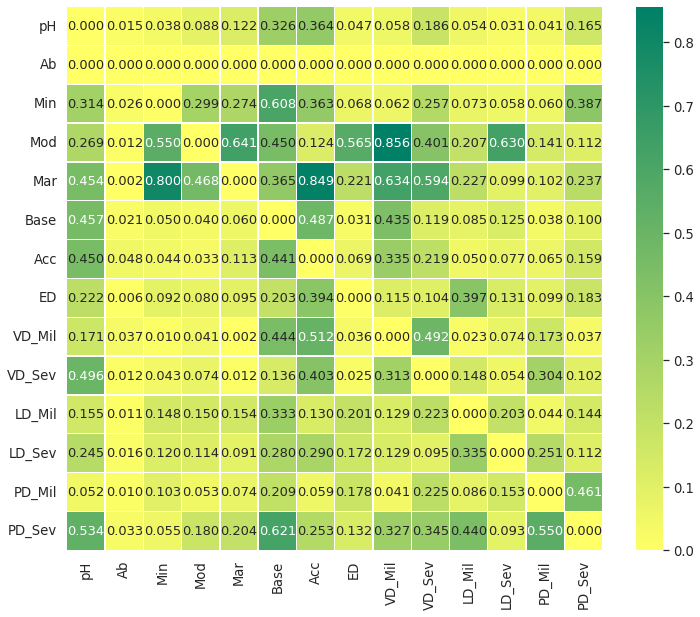

None

In [6]:
show_heatmap('5-0','v6_20220608', origin_data_path='./data/CTU_30m.csv')

Baseline ~ Minimal
Minimal ~ Moderate
Marked ~ Moderate
EarlyDeceleration ~ Moderate
MildVariableDeceleration ~ Moderate
SevereLateDeceleration ~ Moderate
Minimal ~ Marked
Acceleration ~ Marked
MildVariableDeceleration ~ Marked
SevereVariableDeceleration ~ Marked
Acceleration ~ MildVariableDeceleration
pH ~ SevereProlongedDeceleration
Baseline ~ SevereProlongedDeceleration
MildProlongedDeceleration ~ SevereProlongedDeceleration

0.06238


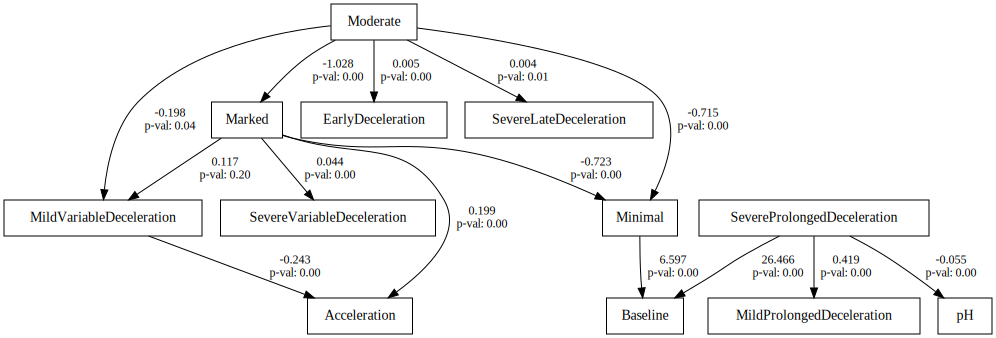

                      Value
DoF            5.400000e+01
DoF Baseline   6.800000e+01
chi2           1.578040e+02
chi2 p-value   4.185763e-12
chi2 Baseline  3.286058e+03
CFI            9.677433e-01
GFI            9.519777e-01
AGFI           9.395275e-01
NFI            9.519777e-01
TLI            9.593804e-01
RMSEA          6.238019e-02
AIC            4.736241e+01
BIC            1.482718e+02
LogLik         3.187959e-01

                          lval  op                         rval     Estimate  \
0                      Minimal   ~                     Moderate    -0.714934   
1                      Minimal   ~                       Marked    -0.722754   
2                       Marked   ~                     Moderate    -1.028222   
3     MildVariableDeceleration   ~                     Moderate    -0.198272   
4     MildVariableDeceleration   ~                       Marked     0.117322   
5                     Baseline   ~                      Minimal     6.597012   
6                  

In [4]:
SEM('5-0', threshold=0.5, origin_data_path='./data/CTU_30m.csv')

Baseline ~ Minimal
Minimal ~ Moderate
Marked ~ Moderate
Baseline ~ Moderate
EarlyDeceleration ~ Moderate
MildVariableDeceleration ~ Moderate
SevereVariableDeceleration ~ Moderate
SevereLateDeceleration ~ Moderate
pH ~ Marked
Minimal ~ Marked
Moderate ~ Marked
Acceleration ~ Marked
MildVariableDeceleration ~ Marked
SevereVariableDeceleration ~ Marked
pH ~ Baseline
Acceleration ~ Baseline
MildVariableDeceleration ~ Baseline
pH ~ Acceleration
Baseline ~ Acceleration
Baseline ~ MildVariableDeceleration
Acceleration ~ MildVariableDeceleration
SevereVariableDeceleration ~ MildVariableDeceleration
pH ~ SevereVariableDeceleration
Acceleration ~ SevereVariableDeceleration
SevereProlongedDeceleration ~ MildProlongedDeceleration
pH ~ SevereProlongedDeceleration
Baseline ~ SevereProlongedDeceleration
MildLateDeceleration ~ SevereProlongedDeceleration
MildProlongedDeceleration ~ SevereProlongedDeceleration



0.05099


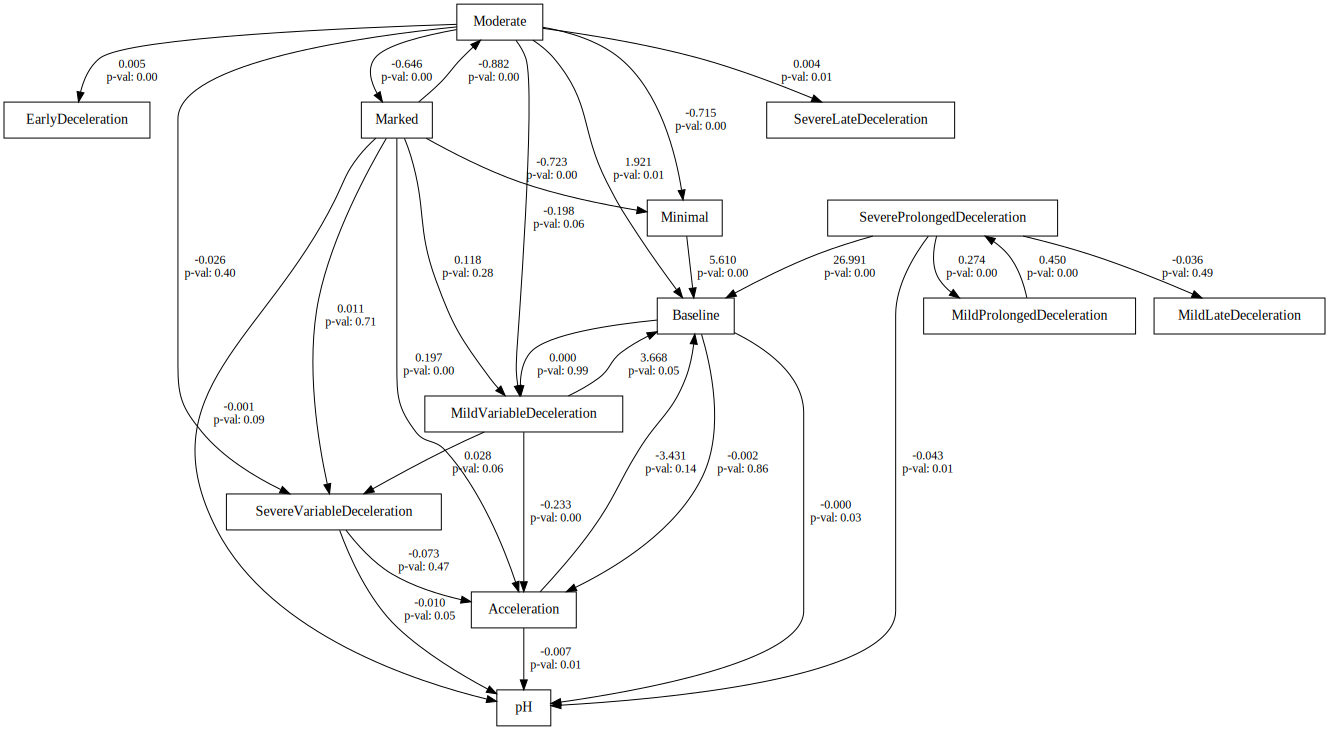

                      Value
DoF            4.900000e+01
DoF Baseline   7.800000e+01
chi2           1.119362e+02
chi2 p-value   7.895458e-07
chi2 Baseline  3.292748e+03
CFI            9.804227e-01
GFI            9.660052e-01
AGFI           9.458859e-01
NFI            9.660052e-01
TLI            9.688361e-01
RMSEA          5.099046e-02
AIC            8.354773e+01
BIC            2.601392e+02
LogLik         2.261338e-01

                           lval  op                         rval    Estimate  \
0                      Baseline   ~                      Minimal    5.610204   
1                      Baseline   ~                     Moderate    1.920862   
2                      Baseline   ~                 Acceleration   -3.430750   
3                      Baseline   ~     MildVariableDeceleration    3.667808   
4                      Baseline   ~  SevereProlongedDeceleration   26.990507   
5                       Minimal   ~                     Moderate   -0.714957   
6                  

In [5]:
SEM('5-0', threshold=0.4, origin_data_path='./data/CTU_30m.csv')

In [8]:
pd.concat(df_evals).to_csv('./sem_graph/df_eval/v8_result.csv', index=False)